# Multiobjective optimization using Kriging models

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS, FullFactorial
from smt.surrogate_models import KRG
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoode.algorithms import NSDE
from pymoode.survival import RankAndCrowding
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.termination.default import DefaultMultiObjectiveTermination

## Branin-Currin optimization problem

In [23]:
# Defining the objective functions
def branin(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    x1 = 15*x[:,0] - 5
    x2 = 15*x[:,1]

    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    t = 1 / (8*np.pi)

    y = (1/51.95)*((x2 - b*x1**2 + c*x1 - 6)**2 + 10*(1-t)*np.cos(x1) + 10 - 44.81)

    if dim == 1:
        y = y.reshape(-1)

    return y

def currin(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    x1 = x[:,0]
    x2 = x[:,1]
    
    factor = 1 - np.exp(-1/(2*x2))
    num = 2300*x1**3 + 1900*x1**2 + 2092*x1 + 60
    den = 100*x1**3 + 500*x1**2 + 4*x1 + 20
    y = factor*num/den
    
    if dim == 1:
        y = y.reshape(-1)

    return y

In [24]:
# Defining the problem class for pymoo - we are evaluating two objective functions in this case
class BraninCurrin(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=np.array([1e-6, 1e-6]), xu=np.array([1, 1]))

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.column_stack((branin(x), currin(x)))

termination = DefaultMultiObjectiveTermination(
    xtol=1e-4,
    cvtol=1e-4,
    ftol=1e-4,
    period=30,
    n_max_gen=1000,
    n_max_evals=100000
)
problem = BraninCurrin()
algorithm = NSDE(pop_size=100, CR=0.9, survival=RankAndCrowding(crowding_func="pcd"), termination = termination, save_history = True)
res_true = minimize(problem, algorithm, verbose=False)

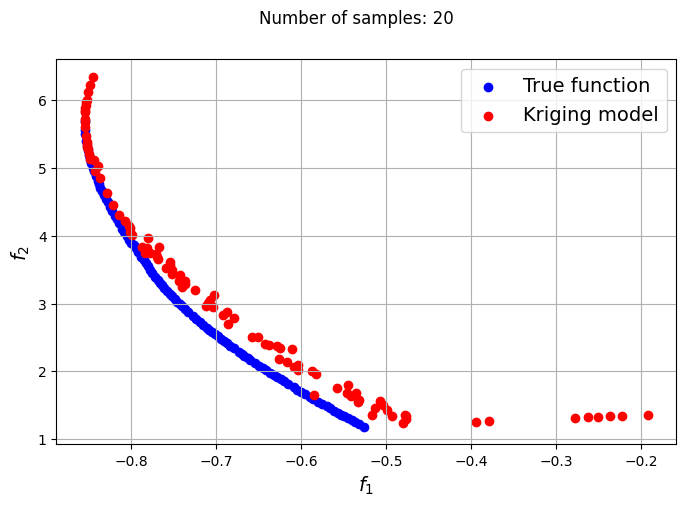

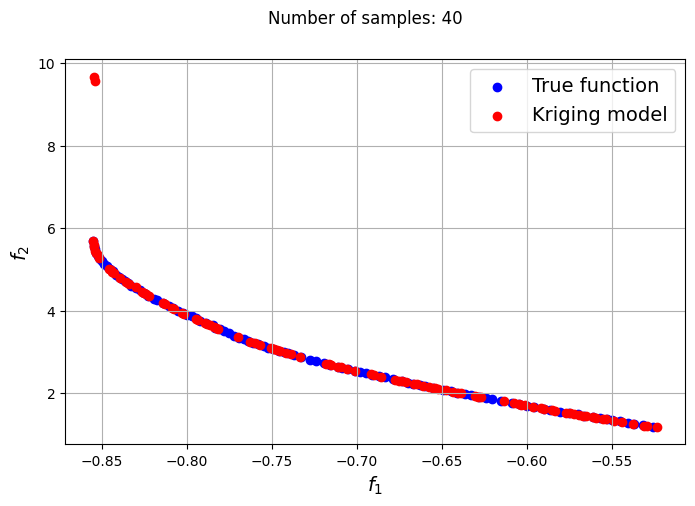

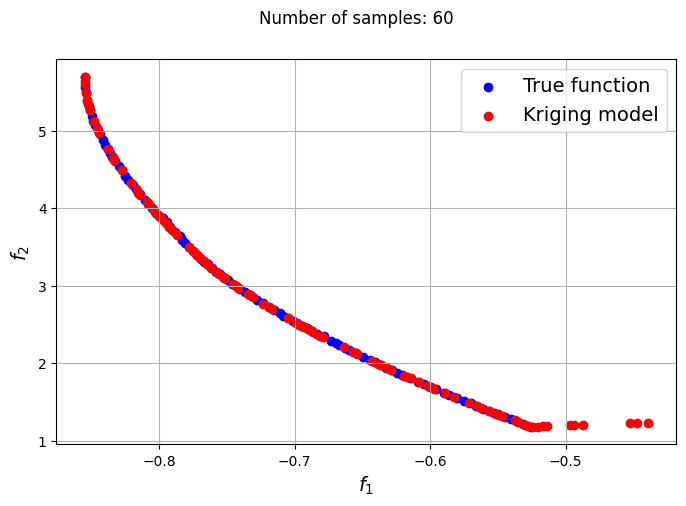

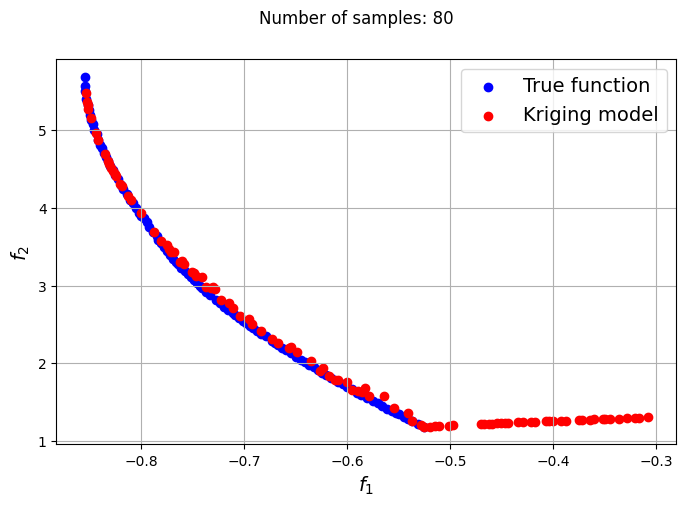

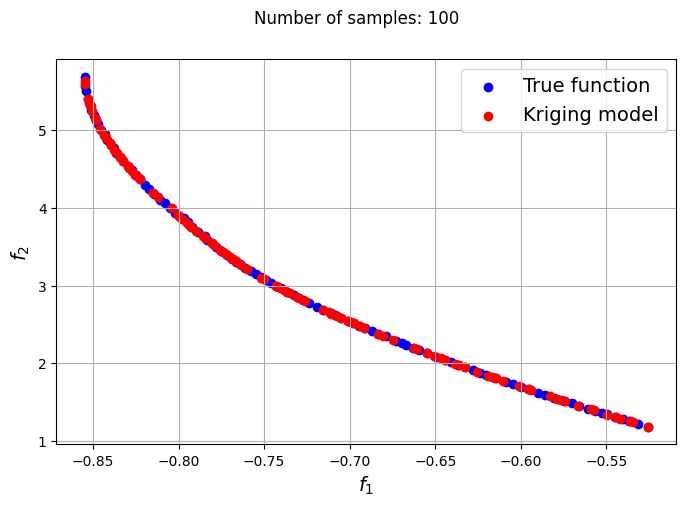

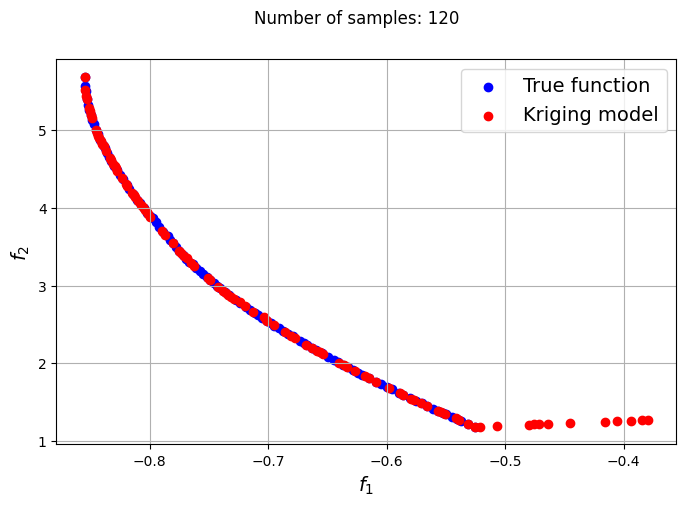

In [25]:
# Defining problem for kriging model based optimization
class KRGBraninCurrin(Problem):

    def __init__(self, sm_branin, sm_currin):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=np.array([1e-6, 1e-6]), xu=np.array([1, 1]))
        self.sm_branin = sm_branin
        self.sm_currin = sm_currin

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.column_stack((sm_branin.predict_values(x), sm_currin.predict_values(x)))

# Defining sample sizes
samples = np.arange(20,140,20)
xlimits = np.array([[1e-6,1.0],[1e-6,1.0]])

for size in samples:

    # Generate training samples using LHS
    sampling = LHS(xlimits=xlimits, criterion="ese")
    xtrain = sampling(size)
    ybranin = branin(xtrain)
    ycurrin = currin(xtrain)
    
    # Create kriging model
    corr = 'squar_exp'
    sm_branin = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_branin.set_training_values(xtrain, ybranin)
    sm_branin.train()

    sm_currin = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_currin.set_training_values(xtrain, ycurrin)
    sm_currin.train()

    problem = KRGBraninCurrin(sm_branin, sm_currin)
    algorithm = NSDE(pop_size=200, CR=0.9, survival=RankAndCrowding(crowding_func="pcd"), termination = termination, save_history = True)
    res_krg = minimize(problem, algorithm, verbose=False)

    F_krg = np.column_stack((branin(res_krg.X), currin(res_krg.X)))
    # Plotting final Pareto frontier obtained
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(res_true.F[:, 0], res_true.F[:, 1], color="blue", label="True function")
    ax.scatter(F_krg[::2, 0], F_krg[::2, 1], color="red", label="Kriging model")
    ax.set_ylabel("$f_2$", fontsize = 14)
    ax.set_xlabel("$f_1$", fontsize = 14)
    ax.legend(fontsize = 14)
    ax.grid()
    fig.suptitle("Number of samples: {}".format(size))


## Constrained multiobjective optimization problem

In [21]:
# Defining the objective functions
def f1(x):
    
    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    y = 4*x[:,0]**2 + 4*x[:,1]**2
    
    return y
    
def f2(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)

    y = (x[:,0]-5)**2 + (x[:,1]-5)**2

    return y

def g1(x):
    
    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)
    
    g = (x[:,0]-5)**2 + x[:,1]**2 - 25

    return g

def g2(x):

    dim = x.ndim
    if dim == 1:
        x = x.reshape(1,-1)
    
    g = 7.7 - ((x[:,0]-8)**2 + (x[:,1]+3)**2)

    return g

# Defining the problem class for pymoo - we are evaluating two objective and two constraint functions in this case
class ConstrainedProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_ieq_constr=2, vtype=float)

        self.xl = np.array([-20.0, -20.0])
        self.xu = np.array([20.0, 20.0])

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.column_stack([f1(x), f2(x)])
        out["G"] = np.column_stack([g1(x), g2(x)])

termination = DefaultMultiObjectiveTermination(
    xtol=1e-3,
    cvtol=1e-3,
    ftol=1e-3,
    period=30,
    n_max_gen=1000,
    n_max_evals=100000
)
problem = ConstrainedProblem()
nsde = NSDE(pop_size=100, CR=0.8, termination = termination, survival=RankAndCrowding(crowding_func="pcd"), save_history = True)
res_true = minimize(problem, nsde, verbose=False)

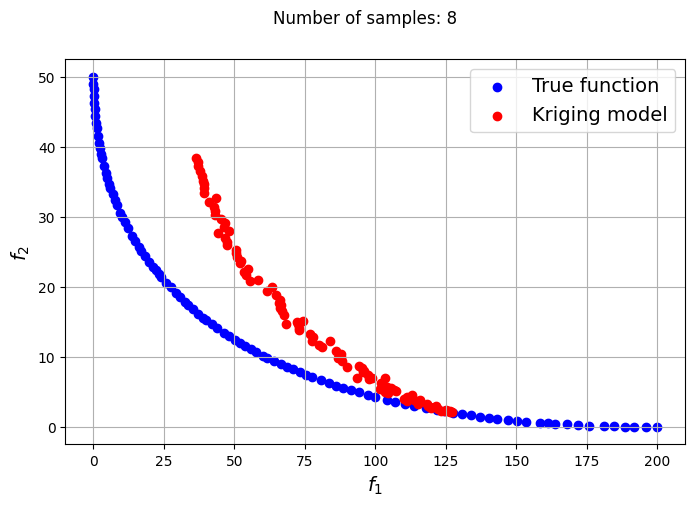

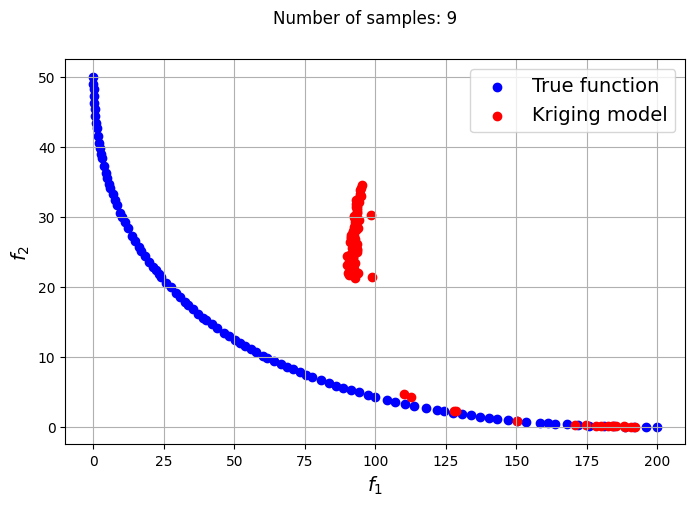

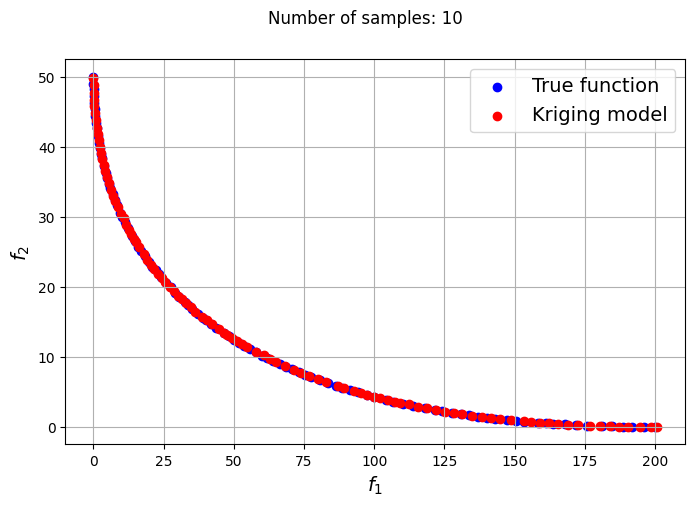

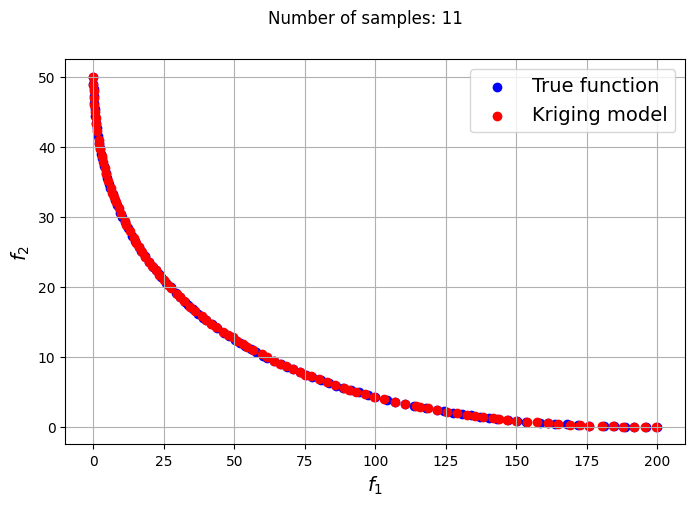

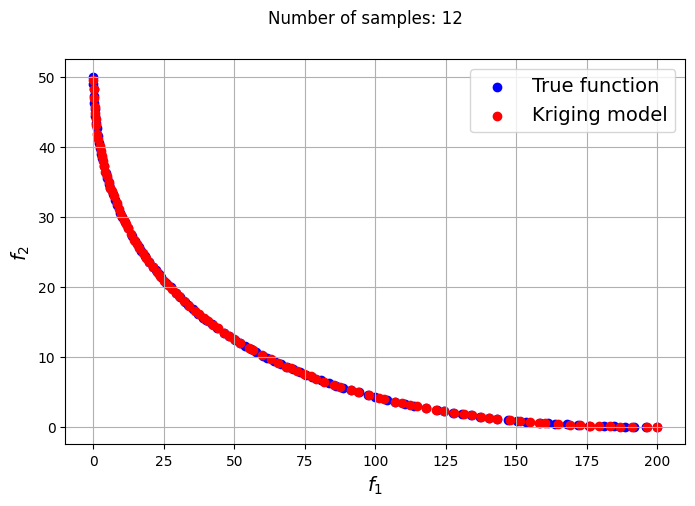

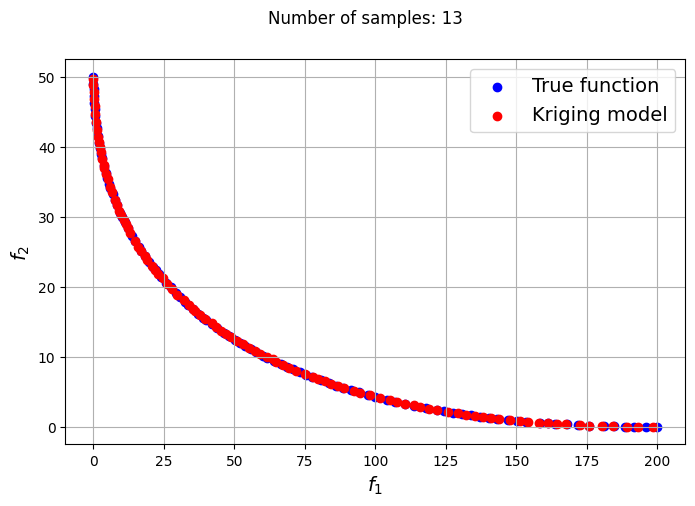

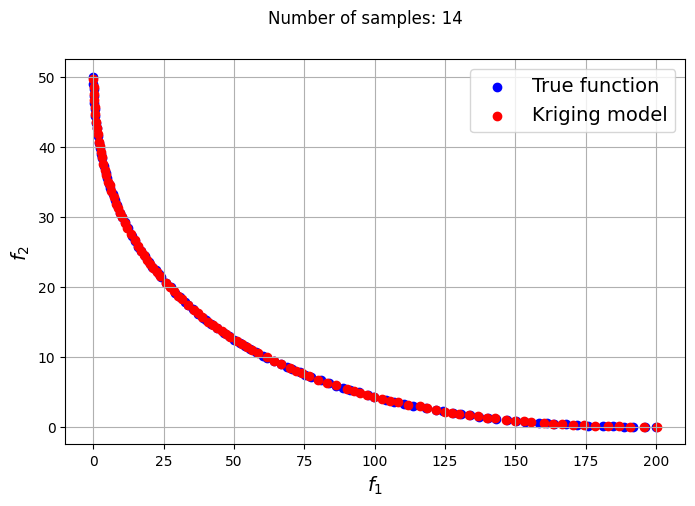

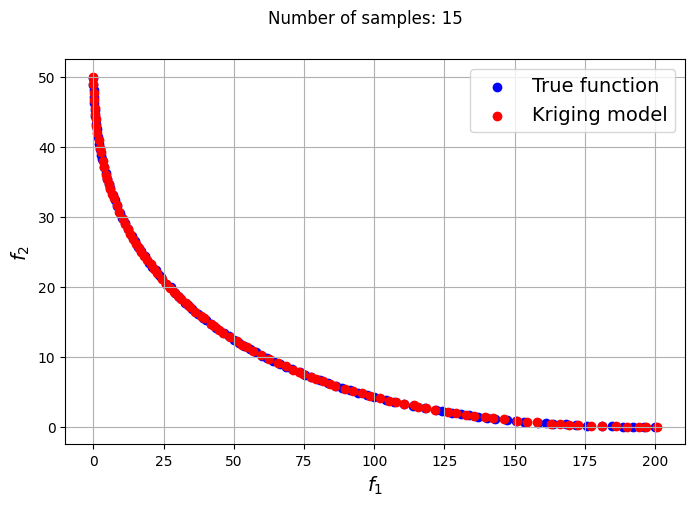

In [22]:
# Defining problem for kriging model based optimization
class KRGProb(Problem):

    def __init__(self, sm_f1, sm_f2, sm_g1, sm_g2):
        super().__init__(n_var=2, n_obj=2, n_ieq_constr=2, vtype=float)

        self.xl = np.array([-20.0, -20.0])
        self.xu = np.array([20.0, 20.0])

        self.sm_f1 = sm_f1
        self.sm_f2 = sm_f2
        self.sm_g1 = sm_g1
        self.sm_g2 = sm_g2

    def _evaluate(self, x, out, *args, **kwargs):

        F1 = self.sm_f1.predict_values(x)
        F2 = self.sm_f2.predict_values(x)
        
        G1 = self.sm_g1.predict_values(x)
        G2 = self.sm_g2.predict_values(x)
        
        out["F"] = np.column_stack((F1, F2))
        out["G"] = np.column_stack((G1, G2))

# Defining sample sizes
samples = [8,9,10,11,12,13,14,15]
xlimits = np.array([[-20.0,20.0],[-20.0,20.0]])

for size in samples:

    # Generate training samples using LHS
    sampling = LHS(xlimits=xlimits, criterion="ese")
    xtrain = sampling(size)
    yf1 = f1(xtrain)
    yf2 = f2(xtrain)
    yg1 = g1(xtrain)
    yg2 = g2(xtrain)
    
    # Create kriging model
    corr = 'squar_exp'
    sm_f1 = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_f1.set_training_values(xtrain, yf1)
    sm_f1.train()

    sm_f2 = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_f2.set_training_values(xtrain, yf2)
    sm_f2.train()
    
    sm_g1 = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_g1.set_training_values(xtrain, yg1)
    sm_g1.train()

    sm_g2 = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_g2.set_training_values(xtrain, yg2)
    sm_g2.train()

    problem = KRGProb(sm_f1, sm_f2, sm_g1, sm_g2)
    algorithm = NSDE(pop_size=100, CR=0.8, survival=RankAndCrowding(crowding_func="pcd"), termination = termination, save_history = True)
    res_krg = minimize(problem, algorithm, verbose=False)
    
    F_krg = np.column_stack((f1(res_krg.X), f2(res_krg.X)))
    # Plotting final Pareto frontier obtained
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(res_true.F[:, 0], res_true.F[:, 1], color="blue", label="True function")
    ax.scatter(F_krg[:, 0], F_krg[:, 1], color="red", label="Kriging model")
    ax.set_ylabel("$f_2$", fontsize = 14)
    ax.set_xlabel("$f_1$", fontsize = 14)
    ax.legend(fontsize = 14)
    ax.grid()
    fig.suptitle("Number of samples: {}".format(size))
